In [2]:
import tensorflow as tf
from models import decoder, encoder, vae, classifier
import pandas as pd
import pathlib
from constants import *
from utils import data_loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [3]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [4]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

y_train, y_validation, y_test, feature_value_names = data_loading.get_feature_dataset(apes_info, FEATURE_NAMES)

Found 10000 files belonging to 10000 classes.


In [5]:
decoder_model = decoder.build_decoder(LATENT_DIM)
encoder_model = encoder.build_encoder(LATENT_DIM)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.load_weights(MODEL_VAE_FILEPATH)

# classifier_model = classifier.build_classifier(encoder_model,
#                                                [512, 1024, 2048],
#                                                [0.10, 0.10, 0.10],
#                                                N_UNIQUE_FEATURES, FEATURE_NAMES)

classifier_model = classifier.build_classifier2(encoder_model)

classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False)] * len(FEATURE_NAMES),
    metrics=["accuracy"],
)

In [6]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 256),                2201184   ['input_3[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 concatenate (Concatenate)   (None, 768)                  0         ['encoder[0][0]',             
                                                                     'encoder[0][1]',    

In [9]:
x_train = data_loading.load_specific_dataset(dataset, train_ids, None)
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(BATCH_SIZE)

x_validation = data_loading.load_specific_dataset(dataset, validation_ids, None)
validation_dataset = tf.data.Dataset.zip((x_validation, y_validation)).batch(BATCH_SIZE)

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CLASSIFIER_FILEPATH,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_CLASSIFIER_FILEPATH, append=True)

In [17]:
history = classifier_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * 20),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, csv_logger],
)

Epoch 1/20


2023-05-25 18:51:38.645910: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype bool and shape [7000,44]
	 [[{{node Placeholder/_20}}]]
2023-05-25 18:51:38.646113: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype bool and shape [7000,44]
	 [[{{node Placeholder/_20}}]]


54/54 [==============================] - 44s 812ms/step - loss: 0.1622 - Mouth_loss: 0.0329 - Background_loss: 0.0038 - Hat_loss: 0.0131 - Eyes_loss: 0.0558 - Clothes_loss: 0.0121 - Fur_loss: 0.0445 - Mouth_accuracy: 0.8063 - Background_accuracy: 0.9967 - Hat_accuracy: 0.9391 - Eyes_accuracy: 0.7530 - Clothes_accuracy: 0.9369 - Fur_accuracy: 0.8419 - val_loss: 0.2976 - val_Mouth_loss: 0.0355 - val_Background_loss: 0.1050 - val_Hat_loss: 0.0145 - val_Eyes_loss: 0.0607 - val_Clothes_loss: 0.0169 - val_Fur_loss: 0.0649 - val_Mouth_accuracy: 0.8033 - val_Background_accuracy: 0.8893 - val_Hat_accuracy: 0.9047 - val_Eyes_accuracy: 0.7220 - val_Clothes_accuracy: 0.8780 - val_Fur_accuracy: 0.7160
Epoch 2/20
54/54 [==============================] - 42s 788ms/step - loss: 0.1600 - Mouth_loss: 0.0328 - Background_loss: 0.0032 - Hat_loss: 0.0132 - Eyes_loss: 0.0546 - Clothes_loss: 0.0117 - Fur_loss: 0.0446 - Mouth_accuracy: 0.8063 - Background_accuracy: 0.9969 - Hat_accuracy: 0.9374 - Eyes_accurac

KeyboardInterrupt: 

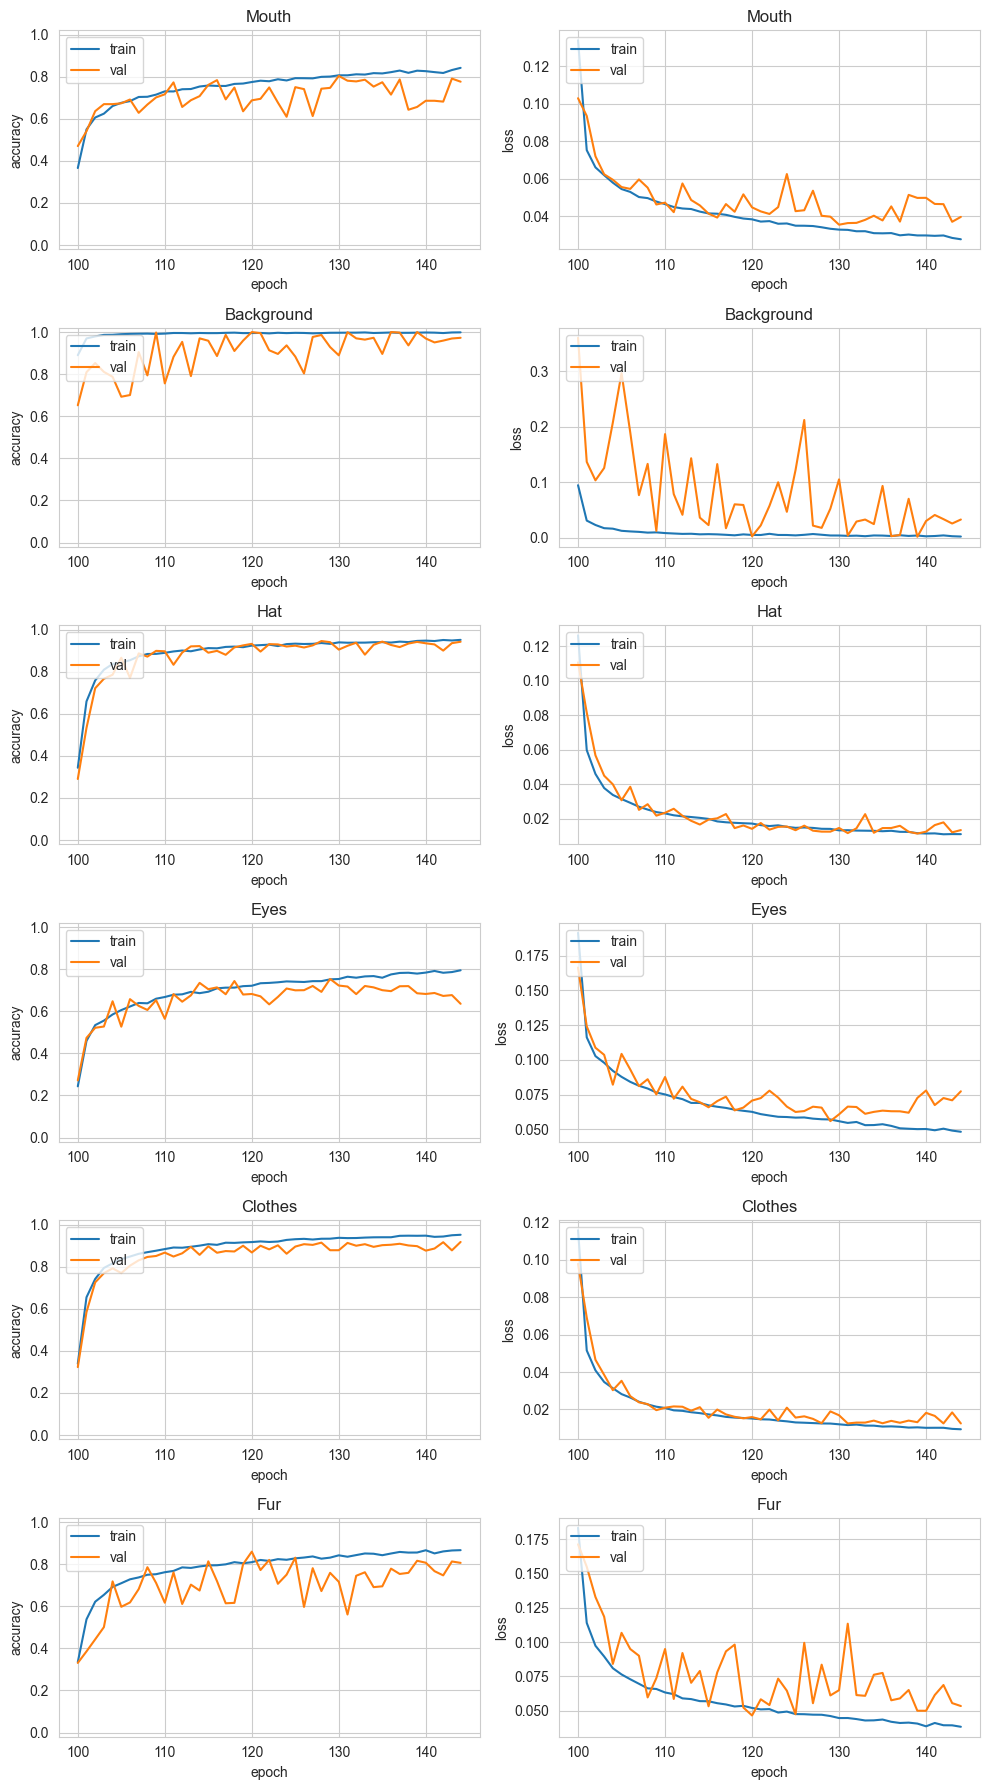

In [23]:
history_classifier_training = pd.read_csv(HISTORY_CLASSIFIER_FILEPATH).iloc[-45:]

plt.figure(figsize=(10, len(FEATURE_NAMES) * 3))

for i, feature_name in enumerate(FEATURE_NAMES):
    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 1)
    plt.plot(history_classifier_training[f"{feature_name}_accuracy"])
    plt.plot(history_classifier_training[f"val_{feature_name}_accuracy"])
    plt.title(feature_name)
    plt.ylim([-0.02, 1.02])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(len(FEATURE_NAMES), 2, i * 2 + 2)
    plt.plot(history_classifier_training[f"{feature_name}_loss"])
    plt.plot(history_classifier_training[f"val_{feature_name}_loss"])
    plt.title(feature_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()

In [19]:
abc = classifier_model.predict(validation_dataset)

12/12 [==============================] - 15s 1s/step


In [20]:
classifier_model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 256),                2201184   ['input_3[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 concatenate (Concatenate)   (None, 768)                  0         ['encoder[0][0]',             
                                                                     'encoder[0][1]',    

In [21]:
a = list(y_validation)

2023-05-25 19:02:51.520566: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype bool and shape [1500,44]
	 [[{{node Placeholder/_8}}]]


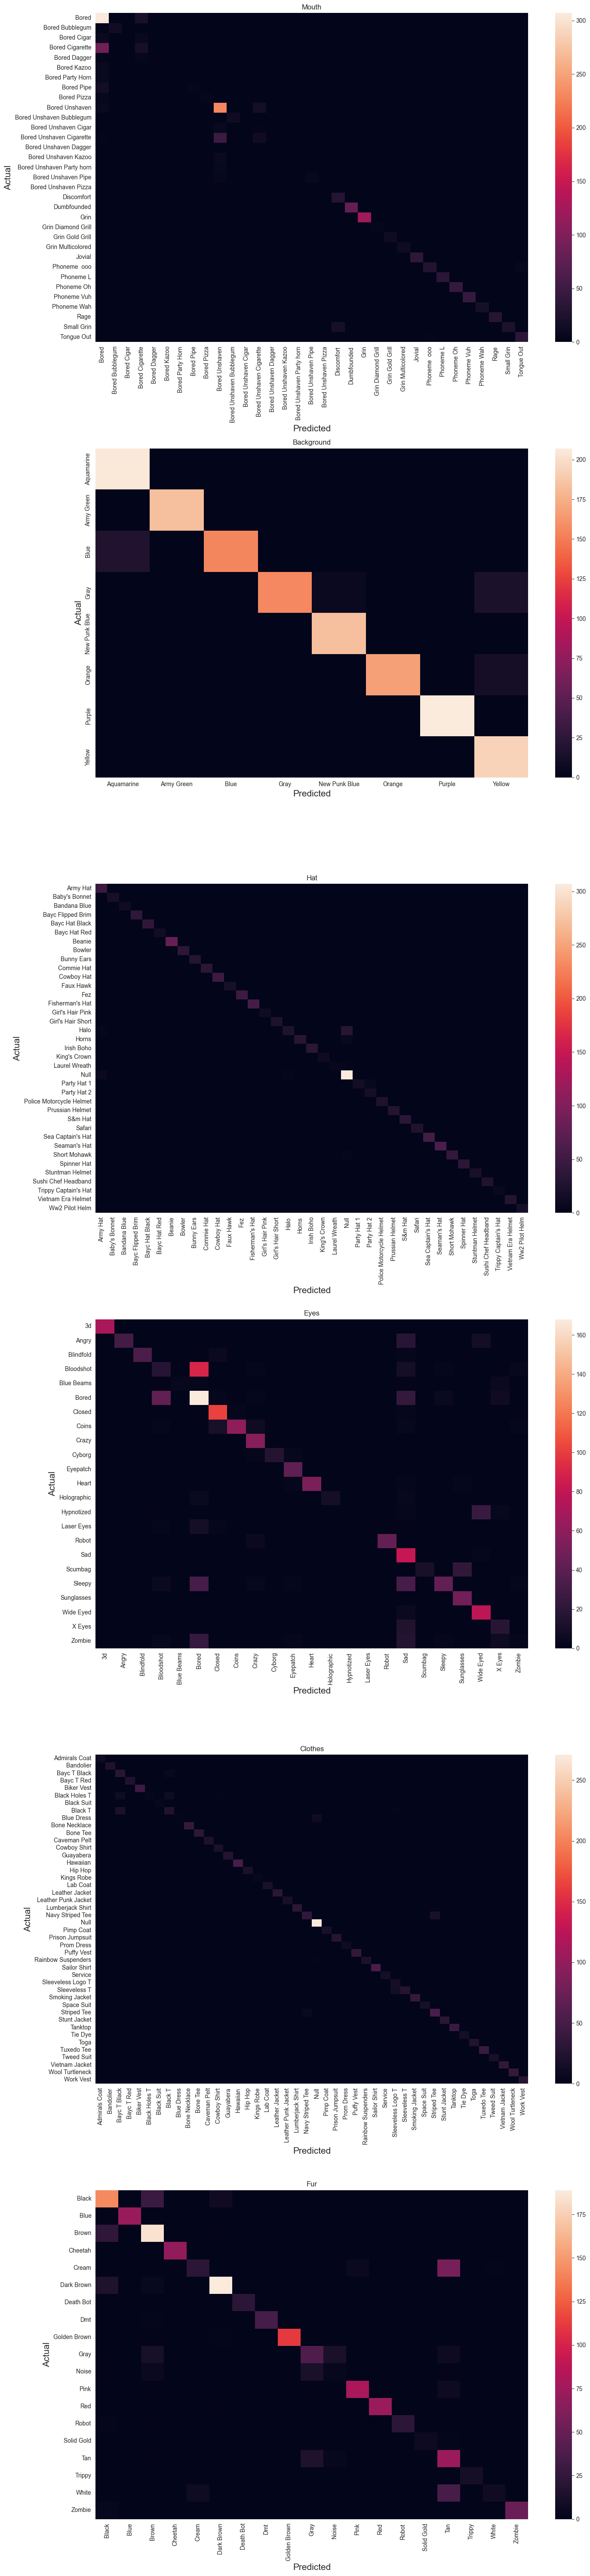

In [22]:
plt.figure(figsize=(15, len(FEATURE_NAMES) * 10))

for i, feature_name in enumerate(FEATURE_NAMES):
    cfm = confusion_matrix(np.argmax([x[i] for x in a], axis=1), np.argmax(abc[i], axis=1))
    df_cm = pd.DataFrame(cfm, index = feature_value_names[feature_name],
                  columns = feature_value_names[feature_name])

    plt.subplot(len(FEATURE_NAMES), 1, i + 1)
    sn.heatmap(df_cm)
    plt.title(feature_name)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)

plt.tight_layout()
plt.show()